In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib widget
import gc


# Register spines
I'll use my interpolated atlas.

Because of the squishing and rotation I think I'll need a slightly different model.

I think I will need a smooth translation as a function of z, an a smooth rotation as a function of z.

# v01
I have the deformation model ready.  Now I need to apply it iteratively.

# v02
In v02 I'm going to crop J

NOTE don't cut out any never roots.

# v04
In v04 I add input for points and lines

# Load and visualize input files I, L and J

In [2]:
# fname_I = '/home/dtward/Documents/UCLA/dong/spine_registration_2025/interpolated_atlas.npz'
# fname_L = '/home/dtward/Documents/UCLA/dong/spine_registration_2025/interpolated_atlas_labels.npz'
# fname_J = '/home/dtward/Documents/UCLA/dong/spine_registration_2025/Spine_Reflection.npz'

fname_I = '/nafs/dtward/spine_work/interpolated_atlas.npz'
fname_L = '/nafs/dtward/spine_work/interpolated_atlas_labels.npz'
fname_J = '/nafs/dtward/spine_work/Spine_Reflection.npz'

pointsJ_file = '/qnap/Spine_Registration/spine4_image_with_reflection/Spine_4_Morphh_Central_Canal.swc'


In [3]:
def draw(I,xI=None,fig=None,function=np.sum,**kwargs):
    if xI is None:
        nI = I.shape[-3:]
        xI = [np.arange(n) - (n-1)/2 for n in nI]
    if fig is None:
        fig = plt.figure()
    dI = [x[1] - x[0] for x in xI]
    I = np.asarray(I)
    fig.clf()
    axs = []
    ax = fig.add_subplot(3,1,1)
    ax.imshow(function(I,-3).squeeze(),extent=(xI[-1][0]-dI[-1]/2, xI[-1][-1]+dI[-1]/2, xI[-2][-1]+dI[-2]/2, xI[-2][0]-dI[-2]/2),**kwargs)
    axs.append(ax)
    
    ax = fig.add_subplot(3,1,2)
    ax.imshow(function(I,-2).squeeze(),extent=(xI[-1][0]-dI[-1]/2, xI[-1][-1]+dI[-1]/2, xI[-3][-1]+dI[-3]/2, xI[-3][0]-dI[-3]/2),**kwargs)
    axs.append(ax)
    
    ax = fig.add_subplot(3,1,3)
    ax.imshow(function(I,-1).squeeze(),extent=(xI[-2][0]-dI[-2]/2, xI[-2][-1]+dI[-2]/2, xI[-3][-1]+dI[-3]/2, xI[-3][0]-dI[-3]/2),**kwargs)
    axs.append(ax)
    return np.array(axs)
    
def getslice(I,ax):
    if ax == -1:
        return I[...,I.shape[-1]//2]
    elif ax == -2:
        return I[...,I.shape[-2]//2,:]
    elif ax == -3:
        return I[...,I.shape[-3]//2,:,:]    

## Load I

In [4]:
data_I = np.load(fname_I,allow_pickle=True)
I = data_I['I']
xI = data_I['xI']

I = I / I.max()

In [6]:
lowert = 0.15
# find a mask for the background
M = I<lowert
I[M] = 1.0
I = (1 - I)
I = I - lowert
I[I<0] = 0

I = I/I.max()

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

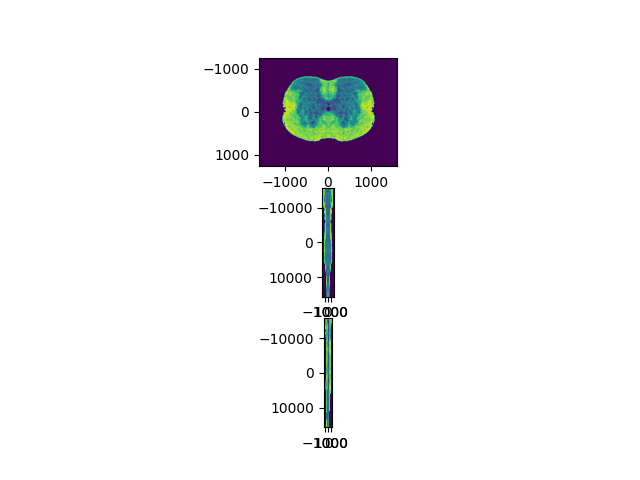

In [7]:
draw(I,xI,function=getslice)

## Load L

In [8]:
data_L = np.load(fname_L,allow_pickle=True)
L = data_L['I']%256
xL = data_L['xI']

print(L.shape)

(1, 3134, 253, 322)


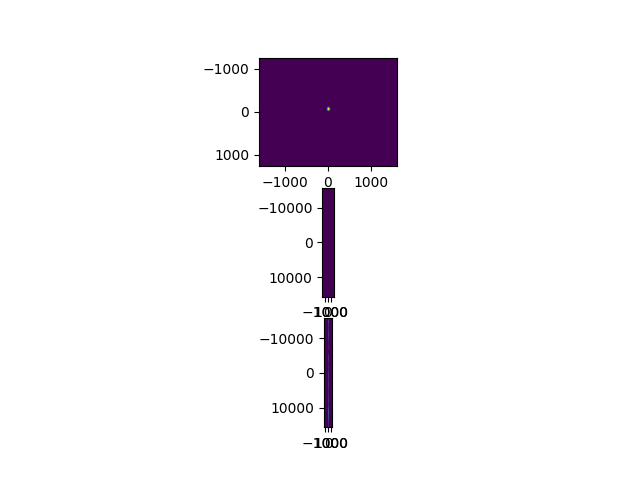

In [9]:
#draw(((L%256)==16) + I,xI,function=getslice)
draw((L%256)==16,xI,)
# get a point cloud
qIU = np.stack(np.meshgrid(*xI,indexing='ij'),-1)[(L[0]%256)==16]


In [10]:
nqU = 1000
qIU = qIU[np.random.permutation(qIU.shape[0])[:nqU]]

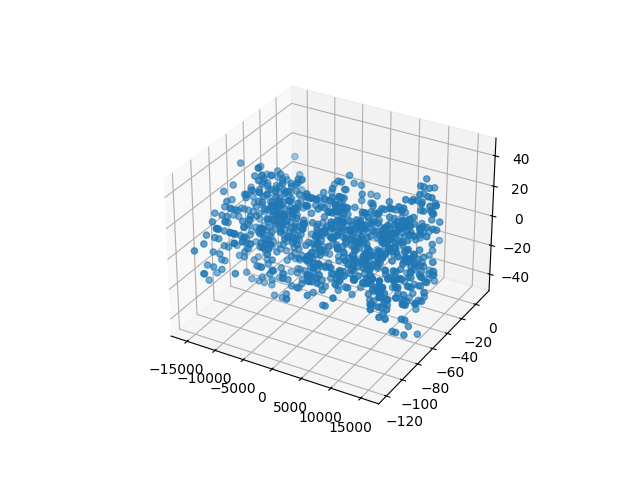

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*qIU.T)
#ax.set_aspect('equal')

In [12]:
SigmaQIU = []
for j in range(3):
    d2 = (qIU[:,None,j] - qIU[None,:,j])**2
    d2i = []
    for i in range(d2.shape[0]):
        d2i.append( np.min( d2[i][d2[i]>0] ) )
    SigmaQIU.append( np.mean(d2i) )
SigmaQIU = np.array(SigmaQIU)
#SigmaQIU = ( np.array([1000.0,50.0,50.0])  )**2

print(SigmaQIU)

[690.2 100.  100. ]


## Load J

In [13]:
#data_J = np.load(fname_J,allow_pickle=True)
#J = data_J['I']
#xJ = data_J['xI']
J = np.load(fname_J.replace('.npz','_I.npy'))
xJ = [
    np.load(fname_J.replace('.npz','_xI0.npy')),
    np.load(fname_J.replace('.npz','_xI1.npy')),
    np.load(fname_J.replace('.npz','_xI2.npy')),
]

print(J.max())

if J.ndim == 3:
    J = J[None]

# center coordinates
xJ = [x - np.mean(x) for x in xJ]

Jsave = J.copy()

FileNotFoundError: [Errno 2] No such file or directory: '/nafs/dtward/spine_work/Spine_Reflection_I.npy'

In [ ]:
draw(I,xI)
draw(J,xJ)

In [21]:
low = 0
high = 1500
J = Jsave.copy().clip(low,high)
WJ = 1.0 - (J == high)
#WJ[:,-60:] = 0 # 60 was good
# we also want to cut off the bottom
J = J - low
J = J / (high-low)

# lets try this
J = J*WJ
WJ = WJ*0+1

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

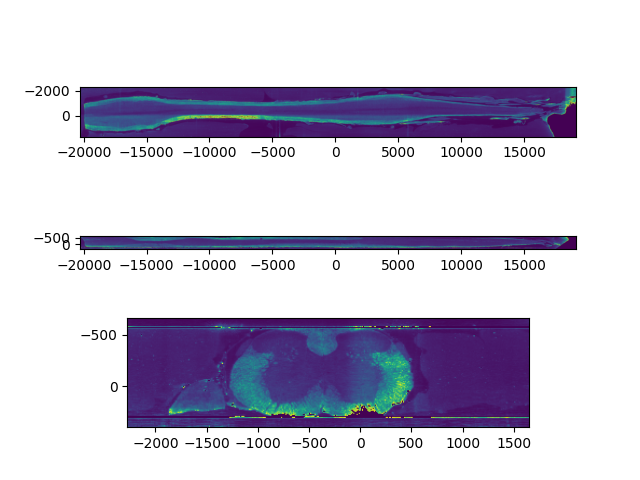

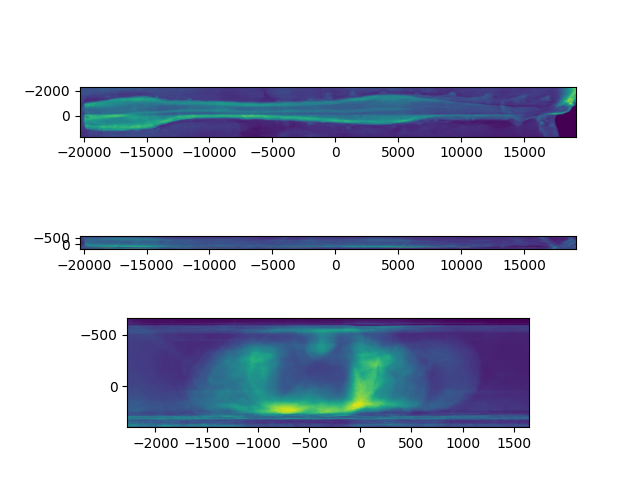

In [22]:
sl = (slice(None),slice(34,-60,None),slice(60,-120,None),slice(200,-310,None))
sl = (slice(None),slice(33,-59,None),slice(59,-119,None),slice(200,-310,None))
sl = (slice(None),slice(24,-50,None),slice(50,-110,None),slice(200,-310,None))
draw((J*WJ)[sl],[x[s] for s,x in zip(sl[1:],xJ)],function=getslice)
draw((J*WJ)[sl],[x[s] for s,x in zip(sl[1:],xJ)])

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

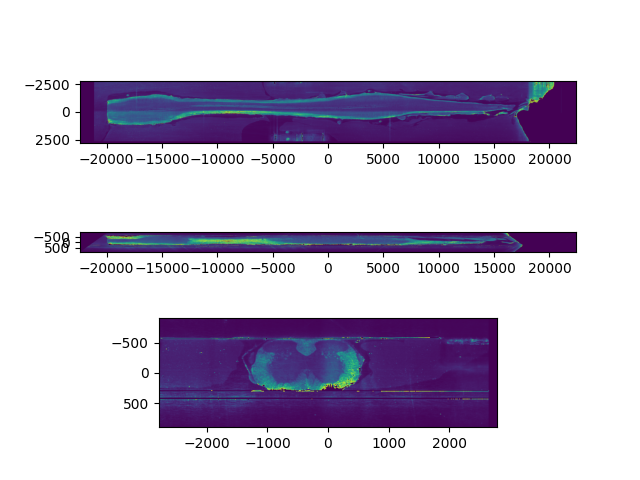

In [23]:
draw(J*WJ,xJ,function=getslice)

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

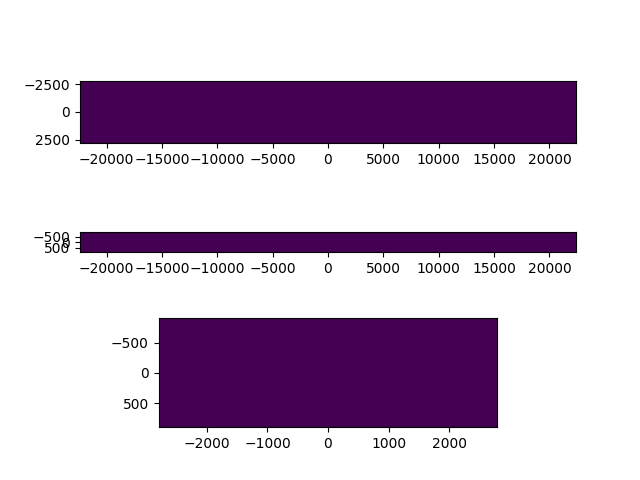

In [24]:
draw(WJ,xJ,function=getslice)

In [19]:
# [x[1] - x[0] for x in xJ],[x[1] - x[0] for x in xI]

In [20]:
# J.shape,[len(x) for x in xJ],I.shape,[len(x) for x in xI],WJ.shape

In [171]:
qJU = []
with open(pointsJ_file) as f:
    for line in f:
        if line.strip()[0] == '#': 
            continue
        items = line.split()[2:5] 
        qi = np.array([float(s) for s in items])
        qJU.append(qi)
qJU = np.stack(qJU)
print(qJU.shape)
qJU = qJU[np.random.randint(low=0,high=qJU.shape[0],size=nqU)]
qJU = qJU + np.random.randn(*qJU.shape)*2

(481, 3)


In [ ]:
# Sumit annotated 481 points here
# we believe the most rostral corresponds to the most rostral atlas.
# do we believe that the last one corresponds to the last one in the atlas? Probabaly 440-450.


In [28]:
dJ = [x[1] - x[0] for x in xJ]
xJ0 = [x[0] for x in xJ]
qJU = qJU[:,::-1]*dJ
#qJ = qJ*dJ
qJU = qJU + xJ0



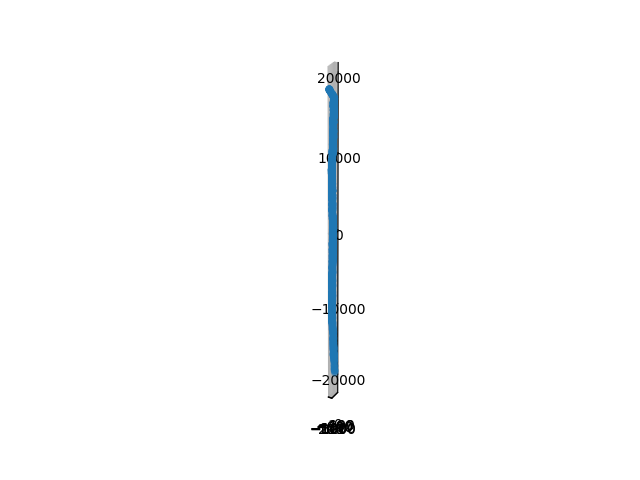

In [29]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*qJU.T)
ax.set_aspect('equal')

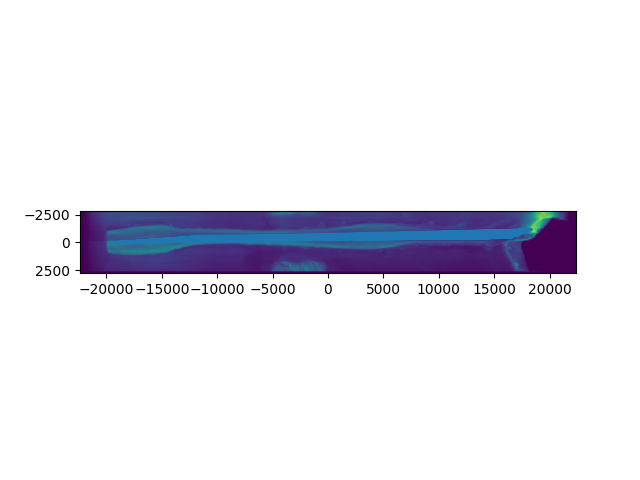

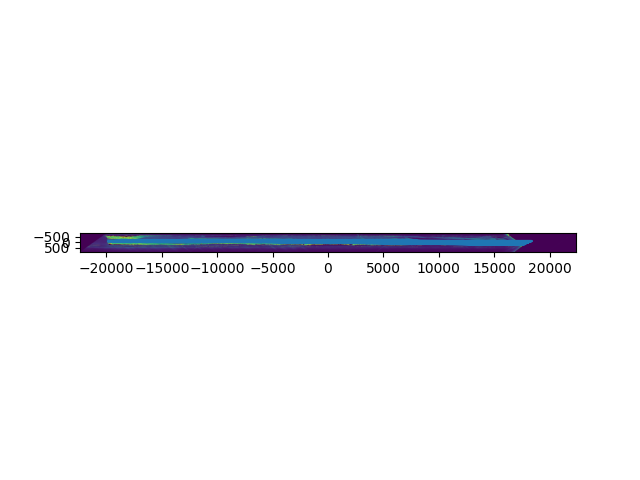

In [30]:
# originally
# nR = array([ 1444,  3110, 25552])
# dR = array([1.24, 1.75, 1.75])
# downsampling = array([8, 6, 6])
# note the last dimension is big, but above the first dimension is big
fig,ax = plt.subplots()
ax.imshow(J.sum((0,1)),extent=(xJ[2][0],xJ[2][-1],xJ[1][-1],xJ[1][0]))
ax.plot(qJU[:,2],qJU[:,1])
# looks like it is right on top, so no scaling necessary
# just flip it
# and multiply by voxel size


fig,ax = plt.subplots()
#ax.imshow(J.sum((0,2)),extent=(xJ[2][0],xJ[2][-1],xJ[0][-1],xJ[0][0]))
ax.imshow(J[0,:,J.shape[2]//2],extent=(xJ[2][0],xJ[2][-1],xJ[0][-1],xJ[0][0]))
ax.plot(qJU[:,2],qJU[:,0])


In [167]:
import sys
sys.path.append('/home/dtward/data/csh_data/emlddmm/')
import emlddmm
down = [2,2,2]
down = [4,4,4]
down = [8,8,8]
xId,Id = emlddmm.downsample_image_domain(xI,I,down)
xJd,Jd,WJd = emlddmm.downsample_image_domain([x[s] for x,s in zip(xJ,sl[1:])],J[sl],down,W=WJ[0][sl[1:]])

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

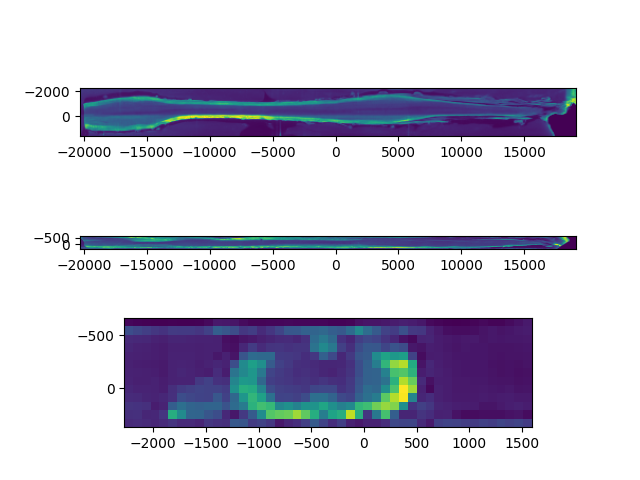

In [32]:
draw(Jd*WJd,xJd,function=getslice)

In [33]:
# we need interpolation
# note there is a batch dimension
def interp(xI,I,Xs,**kwargs):
    Xs = Xs - torch.stack([x[0] for x in xI])
    Xs = Xs / torch.stack([x[-1] - x[0] for x in xI])
    Xs = Xs *2 - 1

    return torch.nn.functional.grid_sample(I[None],Xs[None].flip(-1),align_corners=True,**kwargs)[0]
def interp1d(xI,squish,Xs,**kwargs):
    # set up a hack for 1d interplation    
    # grid sample supports 2D
    # so we will make it 2d
    # use the slice coordinate as the first coordinate, and zeros as the second fake coordinate    
    samples = torch.stack([Xs[...,0].squeeze(),torch.zeros_like(Xs[...,0].squeeze())],-1)
    #print(squish.shape)
    # for the input, we keep the channel dimension, keep the first coordinate, and add a fake second coordinate
    squishin = squish[:,:,None]
    out = interp([xI[0],torch.tensor([-0.5,0.5],**dd)],squishin,samples.reshape(-1,1,2),**kwargs)
    
    return out.reshape((squish.shape[0],)+samples.shape[:-1])    

In [34]:
# we need integration of v, note there is NO batch dimension
def phii_from_v(xv,v):
    dt = 1.0/v.shape[0]
    XV = torch.stack(torch.meshgrid(xv,indexing='ij'),-1)
    phii = XV.clone()#.repeat((v.shape[0],1,1,1))
    for t in range(v.shape[0]):
        Xs = XV - v[t]*dt # Xs should have a batch dimension        
        phii = interp(xv,(phii-XV).permute(3,0,1,2),Xs,padding_mode='border').permute(1,2,3,0) + Xs
    return phii

In [35]:
blocksize = 20
def toblocks(Jd,blocksize):
    nblocks = torch.ceil(torch.tensor(Jd.shape[1:],**dd)/blocksize ).to(int)
    topad = nblocks*blocksize - torch.tensor(Jd.shape[1:],device=device)
    topadlist = [topad[-1],0,topad[-2],0,topad[-3],0] # this pads the left
    Jdp = torch.nn.functional.pad(Jd,topadlist,mode='reflect')
    Jdpv = Jdp.reshape(Jdp.shape[0],nblocks[0],blocksize,nblocks[1],blocksize,nblocks[2],blocksize)
    Jdpp = Jdpv.permute(1,3,5,0,2,4,6)#.reshape(-1,Jdpv.shape[0],blocksize,blocksize,blocksize)
    return Jdpp
def fromblocks(fphiIpp,Jdsize):
    # undo the permutation
    blocksize = fphiIpp.shape[-1]
    nblocks = torch.ceil(torch.tensor(Jdsize[-3:],**dd)/blocksize ).to(int)
    #print(nblocks)
    topad = nblocks*blocksize - torch.tensor(Jdsize[-3:],device=device)
    fphiIpv = fphiIpp.permute(3,0,4,1,5,2,6)
    # NOTE THIS SIZE 1 IS HARD CODED
    fphiIp = fphiIpv.reshape(1,nblocks[0]*blocksize,nblocks[1]*blocksize,nblocks[2]*blocksize)
    #return fphiIp[:,:Jdsize[-3],:Jdsize[-2],:Jdsize[-1]]
    return fphiIp[:,topad[0]:,topad[1]:,topad[2]:]
    
        

In [36]:
device = 'cpu'
dtype = torch.float32
dd = {'device':device,'dtype':dtype}

In [37]:
# convert to torch
Id = torch.tensor(Id,**dd)
Jd = torch.tensor(Jd,**dd)
xId = [torch.tensor(x,**dd) for x in xId]
xJd = [torch.tensor(x,**dd) for x in xJd]
WJd = torch.tensor(WJd,**dd)

XId = torch.stack(torch.meshgrid(xId,indexing='ij'),-1)
XJd = torch.stack(torch.meshgrid(xJd,indexing='ij'),-1)

nId = torch.tensor(Id.shape[-3:],device=device) # int

qIU = torch.tensor(qIU,**dd)
qJU = torch.tensor(qJU,**dd)
SigmaQIU = torch.tensor(SigmaQIU,**dd)

In [38]:
# deformation
nt = 5
dt = 1.0/nt
a = 200.0
p = 2.0
expand = [1.02,1.2,1.2]
dv = a*0.5
vminmax = [(torch.min(x),torch.max(x)) for x in xId]
vr = torch.stack( [(x[1] - x[0]) for x in vminmax]       )
vc = torch.stack( [(x[1]+x[0])/2 for x in vminmax] )
vminmax = vc + (vr*torch.tensor(expand,**dd))*torch.tensor([-1,1],**dd)[...,None]*0.5
xv = [torch.arange(vm[0],vm[1],dv) for vm in vminmax.T]
XV = torch.stack(torch.meshgrid(xv,indexing='ij'),-1)
nv = [len(x) for x in xv]
fv = [torch.arange(n)/n/dv for n in XV.shape[:3]]
FV = torch.stack(torch.meshgrid(fv,indexing='ij'),-1)

LL = (1.0 + 2.0*a**2 * torch.sum(  (1.0 - torch.cos(2.0*np.pi*FV*dv))/dv**2,   -1))**(2.0*p)
K = 1.0/LL

v = torch.zeros(nt,*nv,3,requires_grad=True)



In [39]:
theta = torch.zeros(nv[0],requires_grad=True,**dd)
T = torch.zeros((nv[0],2),requires_grad=True,**dd)
#squish = torch.ones(nv[0],**dd)*(-0.3) # exponentiate it (-0.1 was good), -1 makes it very short and fat in the coronal plane
squish = torch.ones(nv[0],**dd)*(-0.4) # exponentiate it (-0.1 was good), -1 makes it very short and fat in the coronal plane
squish.requires_grad = True

# I'm going to use a kernel matrix
B = torch.exp( -(xv[0][None,:] - xId[0][:,None])**2/2/5000**2)
B = torch.exp( -(xv[0][None,:] - xId[0][:,None])**2/2/2000**2)
B = B / torch.sum(B,1,keepdims=True)
squishb = B@squish

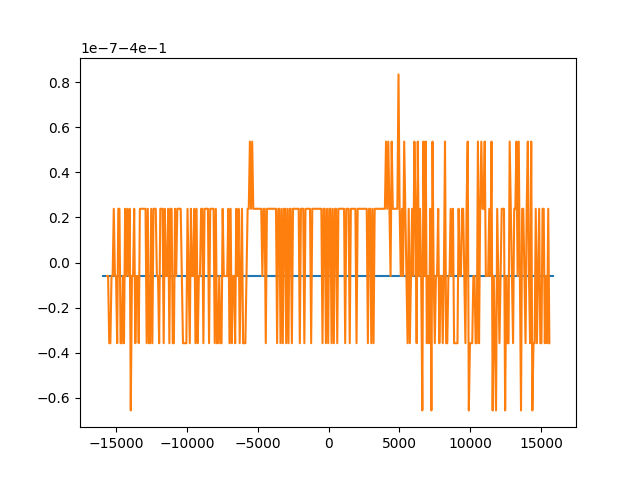

In [40]:
fig,ax = plt.subplots()
ax.plot(xv[0],squish.detach())
ax.plot(xId[0],squishb.detach())

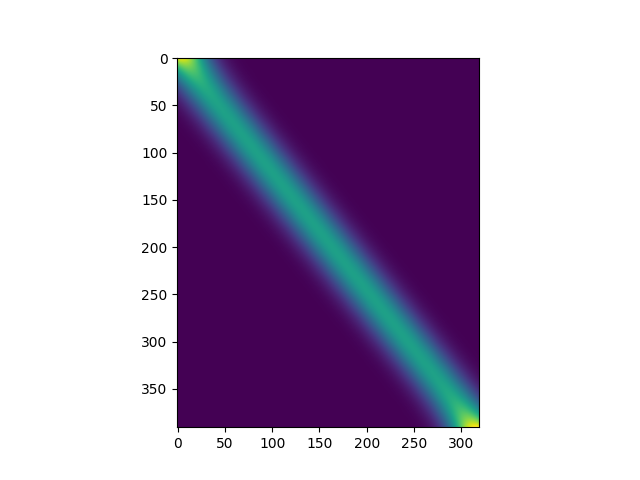

In [41]:
fig,ax = plt.subplots()
ax.imshow(B)

In [42]:
# final permutation (fixed not being optimized)
P = torch.eye(4)[[1,2,0,3]]
A = P
A.requires_grad = True
#stretch = torch.tensor([0.2,0.00,-0.5],requires_grad = True)

#stretch = torch.tensor([0.2,-0.75,-0.75],requires_grad = True)
stretch = torch.tensor([0.2,-0.2,-0.75],requires_grad = True)

# the third number, in the coronal plane, makes it grow left right if it is positive
# should I also add xy scale? or just let the diffeo do it?
#xyscale = torch.tensor()
# if I'm stretching I'll almost surely also need shifting
# leave it for now because they are basically centered

In [43]:
# metric for affine
# since coordinate system is centered at 0, my off diagonal terms will be 0 in the standard push forward approach
# for two basis matrices, we need to evaluate
#gij = int (Eix)^T   Ejx dx = int trace [  x^T Ei^T Ej x ] dx =  int trace [xx^T Ei^TEj]dx = trace [ int xx^T dx Ei^TEj ]
XX = torch.sum(XId[...,None]*XId[...,None,:],(0,1,2))
O = torch.sum(torch.ones_like(XId[...,0]))
XXO = torch.diag(torch.concatenate((torch.diag(XX),O[None])))

In [44]:
g = torch.zeros((12,12),**dd)
count = 0
for i in range(3):
    for j in range(4):
        Eij = (torch.arange(4,**dd)==i)[...,None]*(torch.arange(4,**dd)==j)[...,None,:]*1.0
        count_ = 0
        for i_ in range(3):
            for j_ in range(4):
                Eij_ = (torch.arange(4,**dd)==i_)[...,None]*(torch.arange(4,**dd)==j_)[...,None,:]*1.0
                g[count,count_] = torch.trace( XXO@(Eij.T@Eij_) )

                count_ += 1
                
        count += 1
gi = torch.linalg.inv(g)

In [45]:
from os import makedirs
from os.path import join
outdir = '/home/dtward/Documents/UCLA/dong/spine_registration_2025/outputs_v04'
makedirs(outdir,exist_ok=True)

In [46]:
dJd = [(x[1] - x[0]).item() for x in xJd]

In [47]:
def measure_matching_dot(qIU,wIU,phiiQJU,wphiiQJU,SigmaQIU):
    K = torch.exp( - torch.sum( (qIU[:,None] - phiiQJU[None,:])**2/2/SigmaQIU , -1) )*wIU[:,None]*wphiiQJU[None,:]
    return torch.sum(K)

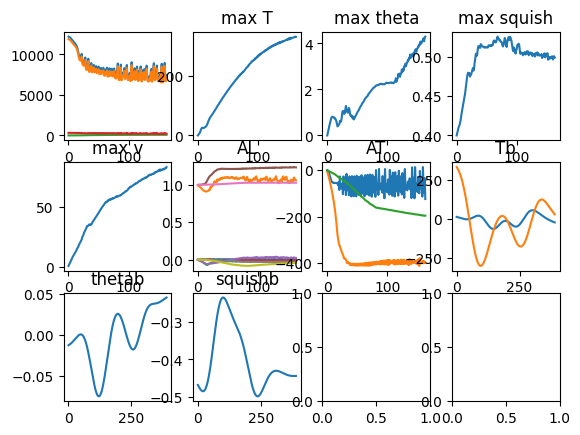

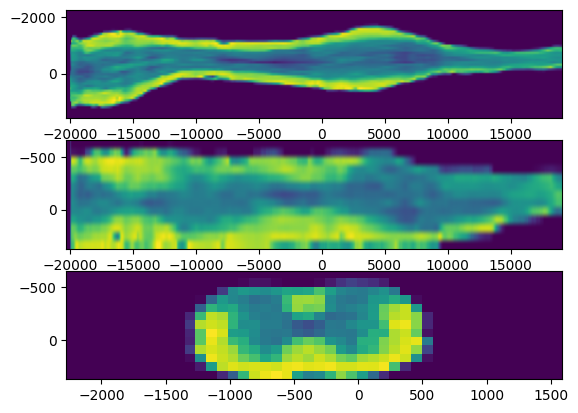

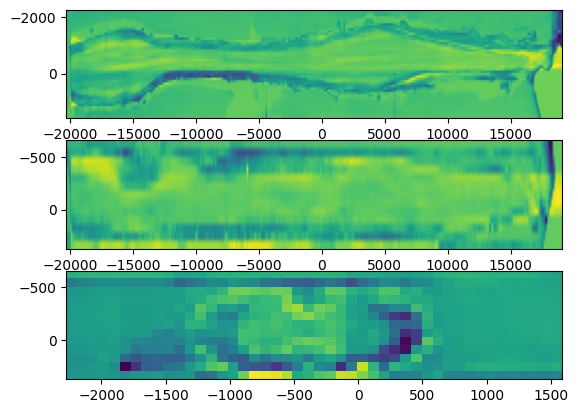

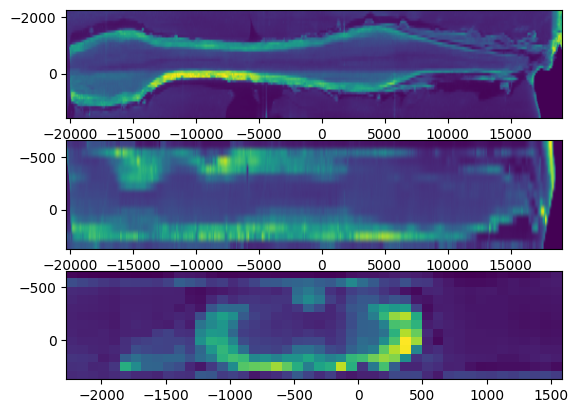

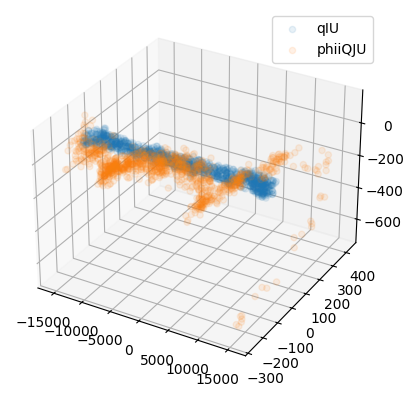

/tmp/ipykernel_3237116/1214260103.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figS,axS = plt.subplots(nrow,ncol)


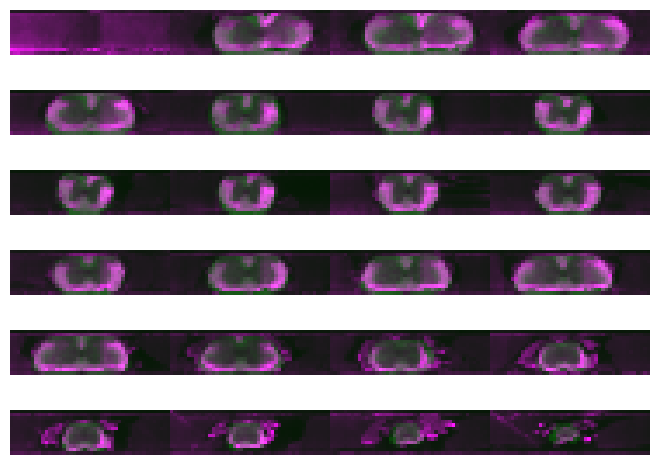

/home/dtward/intelpython3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [48]:

figE,axE = plt.subplots(3,4)
hfigE = display(figE,display_id=True)
axE = axE.ravel()

figI = plt.figure()
hfigI = display(figI,display_id=True)

figErr = plt.figure()
hfigErr = display(figErr,display_id=True)


figJ = plt.figure()
hfigJ = display(figJ,display_id=True)
draw(Jd.detach(),xJd,function=getslice,fig=figJ,aspect='auto')
figJ.canvas.draw()
hfigJ.update(figJ)

figQ = plt.figure()
hfigQ = display(figQ,display_id=True)
axQ = figQ.add_subplot(projection='3d')
axQ.cla()
axQ.scatter(*qIU.T,label='qIU',alpha=0.1)
#axQ.scatter(*phiiQJU.detach().cpu().T,label='phiiQJU',alpha=0.1)
axQ.legend()
hfigQ.update(figQ)


nrow = 6
ncol = 4
figS,axS = plt.subplots(nrow,ncol)
figS.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0,wspace=0)
axS = axS.ravel()
hfigS = display(figS,display_id=True)
    
Esave = []
Tsave = [] # the max
squishsave = []
thetasave = []
vsave = []
ALsave = []
ATsave = []
niter = 5000
update_v = False
vstart = -1
#vstart = 100 # debug
blocksize = 50


# step sizes

epv = 5e4

eptheta = 5e-4
epSquish = 2e-4
epT = 2e2

measureMatchingSigma = SigmaQIU*5**2


sigmaM = (1e5)**0.5
# test
#sigmaM = sigmaM*10
sigmaR = 1e5
sigmaR = 2e5
sigmaQU = 1e-1*50

wIU = torch.ones_like(qIU[...,0])#/qIU.shape[0]*qJU.shape[0]
EQU0 = measure_matching_dot(qIU,wIU,qIU,wIU,measureMatchingSigma) # only compute once
for it in range(0,niter):
    if it > vstart:
        update_v = True

    if it < 500:
        blocksize = 0
    elif it < 1000:
        blocksize = 50
    else:
        blocksize = 32
    # clean up memory
    Xs = None
    Xs0 = None
    phii = None
    out = None
    gc.collect()


    
    # blur 
    thetab = B@theta
    # blur T
    Tb = B@T
    # blur Squish
    squishb = B@squish

    

    # what is the sequence from J to I
    # first inverse affine
    Ai = torch.linalg.inv(A)[:3]
    #Ai = torch.diag(torch.stack([(-stretch).exp(),torch.ones_like(stretch),torch.ones_like(stretch),torch.ones_like(stretch)]))@Ai
    Ai = torch.diag((-stretch).exp())@Ai
    #Ai = torch.diag(torch.stack([(-stretch).exp(),torch.ones_like(stretch),torch.ones_like(stretch),torch.ones_like(stretch)]))@Ai
    Xs = (Ai[:3,:3]@XJd[...,None])[...,0] + Ai[:3,-1]
    # second is the squish    

    # since these operations do not change the z coordinate
    # I can interpolate them all at once
    tosample = torch.concatenate((Tb.T,squishb[None],thetab[None]))    
    out = interp1d(xId,tosample,Xs)

    
    Ts = out[0:2].permute(1,2,3,0)
    squishs = out[2]
    thetas = out[3]

    # these guys only need to be computed once
    eye = torch.diag(torch.ones(3,**dd),)[None,None,None].repeat(Ts.shape[0],Ts.shape[1],Ts.shape[2],1,1)
    zo = torch.tensor([0.0,0.0,0.0,1.0],**dd)[None,None,None,None].repeat(Ts.shape[0],Ts.shape[1],Ts.shape[2],1,1)
    z = torch.zeros_like(Ts[...,0,None],)

    # I don't think I need the bottom row
    #Tmat = torch.concatenate( (eye, torch.concatenate((z,Ts),-1)[...,None] ) , -1)
    Tcat =  torch.concatenate((z,Ts),-1)
    
    
    squishmat = torch.diag_embed(  torch.stack([torch.ones_like(squishs),(-squishs).exp(),(squishs).exp()] ,-1 ) )
    rotmat = torch.stack([
        torch.stack([torch.ones_like(thetas),torch.zeros_like(thetas),torch.zeros_like(thetas)],-1),
        torch.stack([torch.zeros_like(thetas),torch.cos(thetas),torch.sin(thetas)],-1),
        torch.stack([torch.zeros_like(thetas),-torch.sin(thetas),torch.cos(thetas)],-1)
        ],-2)
    
    Xs = Xs - Tcat    
    Xs = (rotmat@squishmat@Xs[...,None])[...,0]

    
    # now the diffeo
    #if update_v:
    phii = phii_from_v(xv,v)
    Xs = interp(xv,(phii-XV).permute(-1,0,1,2),Xs).permute(1,2,3,0) + Xs

    # image
    phiI = interp(xId,Id,Xs)

    # points
    phiiQJU = interp(xJd,Xs.permute(-1,0,1,2),qJU[None,None])[:,0,0].T
    #dphii = torch.linalg.det( torch.stack(torch.gradient(Xs,spacing=dJd,dim=(0,1,2)),-1) )    
    #dphii = interp(xJd,dphii[None],qJU[None,None])[:,0,0].T[...,0]
    
    #dphii = torch.sum((phiiQJU[1:] -  phiiQJU[:-1])**2,-1)**0.5/torch.sum((qJU[1:] -  qJU[:-1])**2,-1)**0.5
    #phiiQJU = (phiiQJU[:-1] + phiiQJU[1:])*0.5
    dphii = torch.ones_like(phiiQJU[...,0])
    if torch.any(dphii)<=0 : raise Exception('negative jacobian')
    
    # contrast
    if blocksize > 0:
        Jdpp = toblocks(Jd,blocksize) # this only needs to be done once
        WJdpp = toblocks(WJd[None],blocksize) # only needs to be done once
        phiIpp = toblocks(phiI,blocksize) # only needs to be done once
    with torch.no_grad():
        if blocksize == 0:
            muI = torch.sum(phiI*WJd)/torch.sum(WJd)
            muJ = torch.sum(Jd*WJd)/torch.sum(WJd)
            varI = torch.sum((phiI-muI)**2*WJd)/torch.sum(WJd)
            covIJ = torch.sum((phiI-muI)*(Jd-muJ)*WJd)/torch.sum(WJd)
        else:
            muI = torch.sum(phiIpp*WJdpp,(-3,-2,-1),keepdims=True)/torch.sum(WJdpp,(-3,-2,-1),keepdims=True)
            muJ = torch.sum(Jdpp*WJdpp,(-3,-2,-1),keepdims=True)/torch.sum(WJdpp,(-3,-2,-1),keepdims=True)
            varI = torch.sum((phiIpp-muI)**2*WJdpp,(-3,-2,-1),keepdims=True)/torch.sum(WJdpp,(-3,-2,-1),keepdims=True)
            covIJ = torch.sum((phiIpp-muI)*(Jdpp-muJ)*WJdpp,(-3,-2,-1),keepdims=True)/torch.sum(WJdpp,(-3,-2,-1),keepdims=True)
    if blocksize > 0:
        fphiIpp = (phiIpp-muI)/(varI + 1e-6)*covIJ + muJ
        fphiI = fromblocks(fphiIpp,Jd.shape)
    else:
        fphiI = (phiI-muI)/(varI + 1e-6)*covIJ + muJ
        
    err = (fphiI-Jd)
    
    EM = (err**2*WJd).sum()/2.0*torch.prod(torch.stack([x[1] - x[0 ] for x in xJd])) /sigmaM**2

    
    ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(-4,-3,-2)))**2,(0,-1))*K)/2.0/nt/v[0,:,:,:,0].numel()/sigmaR**2*torch.prod(torch.stack([x[1] - x[0 ] for x in xJd])) 

    # point matching
    
    EQU = (EQU0 + -2*measure_matching_dot(qIU,wIU,phiiQJU,dphii,measureMatchingSigma) + measure_matching_dot(phiiQJU,dphii,phiiQJU,dphii,measureMatchingSigma))/2.0/sigmaQU**2
    
    
    E = EM + ER + EQU
    E.backward()
    Esave.append([E.item(),EM.item(),ER.item(),EQU.item()])

    # draw it
    draw(err.detach()*WJd,xJd,function=getslice,fig=figErr,aspect='auto')
    figErr.canvas.draw()

    draw(fphiI.detach(),xJd,function=getslice,fig=figI,aspect='auto')
    figI.canvas.draw()
    
    # update parameters    
    theta.data = theta.data - theta.grad*eptheta
    theta.grad.zero_()
    #print(thetab.abs().max())
    
    
    T.data = T.data - T.grad*epT
    T.grad.zero_()
    
    #print(Tb.abs().max())

    
    squish.data = squish.data - squish.grad*epSquish
    squish.grad.zero_()
    #print(squishb.abs().max())
    
    epStretch = 0
    stretch.data = stretch.data - stretch.grad*epStretch
    stretch.grad.zero_()

    if update_v:        
        
        v.data = v.data - torch.fft.ifftn((torch.fft.fftn(v.grad,dim=(1,2,3))*K[...,None]),dim=(1,2,3)).real * epv
        v.grad.zero_()
    

    
    # 1e4 was working but slow, 1e5 still so slow
    # 1e6 working much beter but still quite slow
    # 1e7 was oscilating, but I can confirm that the alignment actually worked
    # try 2e6
    epA = 1e6
    epA = 2e6
    epA = 5e6
    epA = 2e6
    Agrad = (gi@A.grad[:3].ravel()).reshape(3,4)
    A.data[:3] = A.data[:3] - epA*Agrad
    A.grad.zero_()
    ALsave.append(A[:3,:3].clone().detach().ravel().numpy())
    ATsave.append(A[:3,-1].clone().detach().ravel().numpy())


    # draw
    axE[0].cla()
    axE[0].plot(Esave)

    thetasave.append(thetab.clone().detach().abs().max()*180/np.pi)
    Tsave.append(Tb.clone().detach().abs().max())
    squishsave.append(squishb.clone().detach().abs().max())
    vsave.append(v.detach().abs().max())
    axE[1].cla()
    axE[1].plot(Tsave)
    axE[1].set_title("max T")
    axE[2].cla()
    axE[2].plot(thetasave)
    axE[2].set_title("max theta")
    axE[3].cla()
    axE[3].plot(squishsave)
    axE[3].set_title("max squish")

    axE[4].cla()
    axE[4].plot(vsave)
    axE[4].set_title("max v")

    axE[5].cla()
    axE[5].plot(ALsave)
    axE[5].set_title("AL")

    axE[6].cla()
    axE[6].plot(ATsave)
    axE[6].set_title("AT")


    axE[7].cla()
    axE[7].plot(Tb.detach())
    axE[7].set_title("Tb")
    axE[8].cla()
    axE[8].plot(thetab.detach())
    axE[8].set_title("thetab")
    axE[9].cla()
    axE[9].plot(squishb.detach())
    axE[9].set_title("squishb")
    
    figE.canvas.draw()


    axQ.cla()
    axQ.scatter(*qIU.T,label='qIU',alpha=0.1)
    axQ.scatter(*phiiQJU.detach().cpu().T,label='phiiQJU',alpha=0.1)
    axQ.legend()
    figQ.canvas.draw()
    figQ.savefig(join(outdir,f'out_Q_it_{it:06d}.png'))
    



    hfigErr.update(figErr)
    hfigI.update(figI)
    hfigE.update(figE)
    hfigQ.update(figQ)
    figErr.savefig(join(outdir,f'out_err_it_{it:06d}.png'))
    
    
    


    # show a better figure
    
    nshow = nrow*ncol    
    
    slices = np.round(np.linspace(0,Jd.shape[-1]-1,nshow+2)).astype(int)
    for i in range(nshow):
        Jshow = (Jd[0,:,:,slices[i]]*WJd[:,:,slices[i]]).numpy()
        Jshow = Jshow/np.max(Jshow)
        Ishow = fphiI[0,:,:,slices[i]].detach().numpy()/np.max(Jshow)
        axS[i].imshow(np.stack((Jshow,Ishow,Jshow),-1))
        axS[i].axis('off')
    
    figS.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0,wspace=0)
    hfigS.update(figS)
    figS.savefig(join(outdir,f'out_S_it_{it:06d}.png'))
    
    

    

In [ ]:
asdf

# prepare outputs

In [57]:
# first thing to do is just save the parameters
np.savez(join(outdir,'saved_parameters.npz'),
         theta=theta.detach().cpu().numpy(),
         T=T.detach().cpu().numpy(),
         squish=squish.detach().cpu().numpy(),
         B=B.detach().cpu().numpy(),
         A=A.detach().cpu().numpy(),
         v=v.detach().cpu().numpy(),
         xv=np.array([x.detach().cpu().numpy() for x in xv],dtype=object),
         xId=np.array([x.detach().cpu().numpy() for x in xId],dtype=object),
         xJd=np.array([x.detach().cpu().numpy() for x in xJd],dtype=object)
        )


In [99]:
# save the forward and inverse transform
with torch.no_grad():
    # blur 
    thetab = B@theta
    # blur T
    Tb = B@T
    # blur Squish
    squishb = B@squish

    

    # what is the sequence from J to I
    # first inverse affine
    Ai = torch.linalg.inv(A)[:3]
    #Ai = torch.diag(torch.stack([(-stretch).exp(),torch.ones_like(stretch),torch.ones_like(stretch),torch.ones_like(stretch)]))@Ai
    Ai = torch.diag((-stretch).exp())@Ai
    #Ai = torch.diag(torch.stack([(-stretch).exp(),torch.ones_like(stretch),torch.ones_like(stretch),torch.ones_like(stretch)]))@Ai
    Xs = (Ai[:3,:3]@XJd[...,None])[...,0] + Ai[:3,-1]
    # second is the squish    

    # since these operations do not change the z coordinate
    # I can interpolate them all at once
    tosample = torch.concatenate((Tb.T,squishb[None],thetab[None]))    
    out = interp1d(xId,tosample,Xs)

    
    Ts = out[0:2].permute(1,2,3,0)
    squishs = out[2]
    thetas = out[3]

    # these guys only need to be computed once
    eye = torch.diag(torch.ones(3,**dd),)[None,None,None].repeat(Ts.shape[0],Ts.shape[1],Ts.shape[2],1,1)
    zo = torch.tensor([0.0,0.0,0.0,1.0],**dd)[None,None,None,None].repeat(Ts.shape[0],Ts.shape[1],Ts.shape[2],1,1)
    z = torch.zeros_like(Ts[...,0,None],)

    # I don't think I need the bottom row
    #Tmat = torch.concatenate( (eye, torch.concatenate((z,Ts),-1)[...,None] ) , -1)
    Tcat =  torch.concatenate((z,Ts),-1)
    
    
    squishmat = torch.diag_embed(  torch.stack([torch.ones_like(squishs),(-squishs).exp(),(squishs).exp()] ,-1 ) )
    rotmat = torch.stack([
        torch.stack([torch.ones_like(thetas),torch.zeros_like(thetas),torch.zeros_like(thetas)],-1),
        torch.stack([torch.zeros_like(thetas),torch.cos(thetas),torch.sin(thetas)],-1),
        torch.stack([torch.zeros_like(thetas),-torch.sin(thetas),torch.cos(thetas)],-1)
        ],-2)
    
    Xs = Xs - Tcat    
    Xs = (rotmat@squishmat@Xs[...,None])[...,0]

    
    # now the diffeo
    #if update_v:
    phii = phii_from_v(xv,v)
    Xs = interp(xv,(phii-XV).permute(-1,0,1,2),Xs).permute(1,2,3,0) + Xs

np.savez(join(outdir,'inverse_transform.npz'),phii=Xs.detach().cpu().numpy(),x=np.array([x.detach().cpu().numpy() for x in xJd],dtype=object))

# now a high res version

In [123]:
# and a high res version of the inverse
# we need some kind of boundary condition here for interpolation
# Xs is not close to identity
# but it is close to some affine transformation
# min_A |A XJ - Xs|^2
# A = XJXs / (XJXJ)
# I need the row of ones
XJd_ = torch.concatenate((XJd,torch.ones_like(XJd[...,0,None])),-1)
Xs_ = torch.concatenate((Xs.detach(),torch.ones_like(XJd[...,0,None])),-1)
fit = torch.linalg.solve( XJd_.reshape(-1,4).T@XJd_.reshape(-1,4), XJd_.reshape(-1,4).T @ Xs_.detach().reshape(-1,4) ).T
FIT = (fit[:3,:3]@XJd_[...,:3,None])[...,0] + fit[:3,-1]

In [131]:
torch.mean((Xs - FIT)**2),torch.mean(Xs**2)

(tensor(15850.8584), tensor(27931336.))

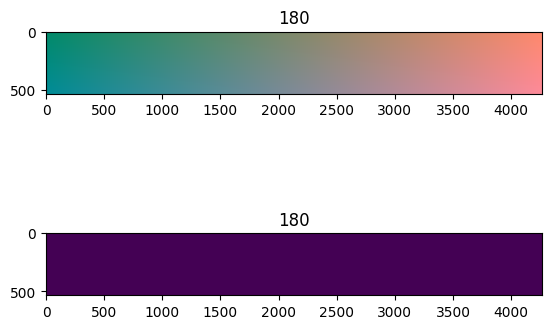

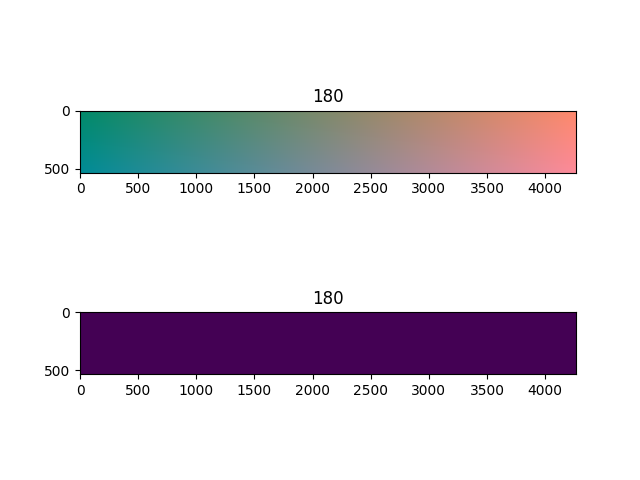

In [146]:
fig,ax = plt.subplots(2,1)
hfig = display(fig,display_id=True)
OUT = []
for i in range(0,J.shape[1],1):
    # get the location
    thisx = [[xJ[0][i]],xJ[1],xJ[2]]
    thisX = np.stack(np.meshgrid(*thisx,indexing='ij'),-1)
    # interpolate Xs
    #out = interp(xJd,(Xs-XJd).clone().detach().permute(-1,0,1,2),torch.tensor(thisX,**dd)).permute(1,2,3,0) + torch.tensor(thisX,**dd)
    #out = interp(xJd,(Xs).clone().detach().permute(-1,0,1,2),torch.tensor(thisX,**dd)).permute(1,2,3,0) 
    # now when I fill with zeros the result will be appropriate
    thisXfit = (fit[:3,:3]@thisX[...,None])[...,0] + fit[:3,-1]    
    out = interp(xJd,(Xs-FIT).clone().detach().permute(-1,0,1,2),torch.tensor(thisX,**dd)).permute(1,2,3,0) + thisXfit.float()
    
    bad = out==0
    test = interp(xId,Id,out)
    #
    ax[0].cla()
    ax[0].imshow((out[0] - out.min())/(out.max()-out.min()))
    ax[0].set_title(i)
    ax[1].cla()
    ax[1].imshow(test.squeeze())
    ax[1].set_title(i)
    hfig.update(fig)

    # scale
    out = out - torch.tensor([xI[0][0],xI[1][0],xI[2][0]],**dd)
    out = out / ( torch.tensor([xI[0][1] - xI[0][0],xI[1][1] - xI[1][0],xI[2][1] - xI[2][0]],**dd))
    #out[bad] = -1
    OUT.append(out)
OUT = torch.concatenate(OUT)
OUT = OUT.numpy()

In [147]:
# write it out
np.save(join(outdir,'interpolated_atlas_to_spine_reflection_v04.npy'),OUT)

In [163]:
# save the forward and inverse transform
with torch.no_grad():
    # blur 
    thetab = B@theta
    # blur T
    Tb = B@T
    # blur Squish
    squishb = B@squish

    # forward phi
    phi = phii_from_v(xv,-v.flip(0))

    # start with XId
    Xs = XId.clone()
    
    # then apply phi
    Xs = interp(xv,(phi-XV).permute(-1,0,1,2),Xs).permute(1,2,3,0) + Xs
    
    # then we can compose the other transformations
    # since these operations do not change the z coordinate
    # I can interpolate them all at once
    tosample = torch.concatenate((Tb.T,squishb[None],thetab[None]))    
    out = interp1d(xId,tosample,Xs)
    Ts = out[0:2].permute(1,2,3,0)
    squishs = out[2]
    thetas = out[3]

    # these guys only need to be computed once
    eye = torch.diag(torch.ones(3,**dd),)[None,None,None].repeat(Ts.shape[0],Ts.shape[1],Ts.shape[2],1,1)
    zo = torch.tensor([0.0,0.0,0.0,1.0],**dd)[None,None,None,None].repeat(Ts.shape[0],Ts.shape[1],Ts.shape[2],1,1)
    z = torch.zeros_like(Ts[...,0,None],)
    Tcat =  torch.concatenate((z,Ts),-1) # I'm leaving the sign here the same
    squishmat = torch.diag_embed(  torch.stack([torch.ones_like(squishs),(squishs).exp(),(squishs).exp()] ,-1 ) ) # note I deleted the minus sign as compared to above
    rotmat = torch.stack([
        torch.stack([torch.ones_like(thetas),torch.zeros_like(thetas),torch.zeros_like(thetas)],-1),
        torch.stack([torch.zeros_like(thetas),torch.cos(thetas),-torch.sin(thetas)],-1), # note I moved the minus sign as compared to above
        torch.stack([torch.zeros_like(thetas),torch.sin(thetas),torch.cos(thetas)],-1)
        ],-2)
    # before the order was translate, squish, rotate
    # so now we do, rotate, squish translate
    Xs = (squishmat@rotmat@Xs[...,None])[...,0]
    Xs = Xs + Tcat

    



    
    # last the affine, and the streching is part of it
    A_ = A[:3,:3]@torch.diag(stretch.exp()) + A[:3,-1]
    Xs = (A_[:3,:3]@Xs[...,None])[...,0] + A_[:3,-1]

    
np.savez(join(outdir,'forward_transform.npz'),phi=Xs.detach().cpu().numpy(),x=np.array([x.detach().cpu().numpy() for x in xId],dtype=object))

In [164]:
# and a high res version of the inverse
# we need some kind of boundary condition here for interpolation
# Xs is not close to identity
# but it is close to some affine transformation
# min_A |A XJ - Xs|^2
# A = XJXs / (XJXJ)
# I need the row of ones
XId_ = torch.concatenate((XId,torch.ones_like(XId[...,0,None])),-1)
Xs_ = torch.concatenate((Xs.detach(),torch.ones_like(XId[...,0,None])),-1)
fit = torch.linalg.solve( XId_.reshape(-1,4).T@XId_.reshape(-1,4), XId_.reshape(-1,4).T @ Xs_.detach().reshape(-1,4) ).T
FIT = (fit[:3,:3]@XId_[...,:3,None])[...,0] + fit[:3,-1]

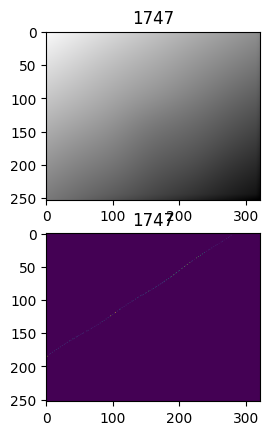

KeyboardInterrupt: 

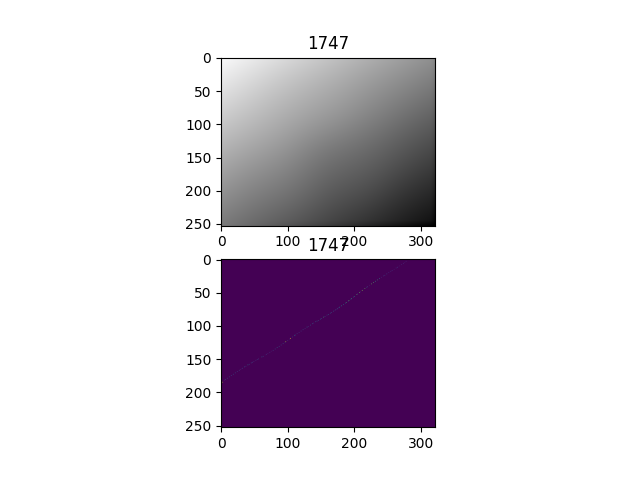

In [165]:
fig,ax = plt.subplots(2,1)
hfig = display(fig,display_id=True)
OUT = []
for i in range(0,I.shape[1],1):
    # get the location
    thisx = [[xI[0][i]],xI[1],xI[2]]
    thisX = np.stack(np.meshgrid(*thisx,indexing='ij'),-1)
    # interpolate Xs
    #out = interp(xJd,(Xs-XJd).clone().detach().permute(-1,0,1,2),torch.tensor(thisX,**dd)).permute(1,2,3,0) + torch.tensor(thisX,**dd)
    #out = interp(xId,(Xs).clone().detach().permute(-1,0,1,2),torch.tensor(thisX,**dd)).permute(1,2,3,0) 
    thisXfit = (fit[:3,:3]@thisX[...,None])[...,0] + fit[:3,-1]    
    out = interp(xId,(Xs-FIT).clone().detach().permute(-1,0,1,2),torch.tensor(thisX,**dd)).permute(1,2,3,0) + thisXfit.float()
    
    bad = out==0
    test = interp(xJd,Jd,out)
    #
    ax[0].cla()
    ax[0].imshow((out[0] - out.min())/(out.max()-out.min()))
    ax[0].set_title(i)
    ax[1].cla()
    ax[1].imshow(test.squeeze())
    ax[1].set_title(i)
    hfig.update(fig)

    # scale
    out = out - torch.tensor([xJ[0][0],xJ[1][0],xJ[2][0]],**dd)
    out = out / ( torch.tensor([xJ[0][1] - xJ[0][0],xJ[1][1] - xJ[1][0],xJ[2][1] - xJ[2][0]],**dd))
    out[bad] = -1
    OUT.append(out)
OUT = torch.concatenate(OUT)
OUT = OUT.numpy()

In [ ]:
OUT.shape

In [ ]:
fig,ax = plt.subplots()
ax.imshow((out[0] - out.min())/(out.max()-out.min()))

fig,ax = plt.subplots()
ax.imshow((Xs.detach()[i] - Xs.detach()[i].min())/(Xs.detach()[i].max()-Xs.detach()[i].min()))

In [ ]:
asdf

In [ ]:
# todo blockwize contrast
# use fphiI and Jd
blocksize = 20
# work out how much needs to be padded
# pad with reflection
# estimate contrast in blocks
# appply changes
# crop
fphiI.shape
nblocks = torch.ceil(torch.tensor(fphiI.shape[1:],**dd)/blocksize ).to(int)
print(nblocks)
topad = nblocks*blocksize - torch.tensor(fphiI.shape[1:],device=device)
topadlist = [topad[-1],0,topad[-2],0,topad[-3],0]
fphiIp = torch.nn.functional.pad(fphiI,topadlist,mode='reflect')
Jdp = torch.nn.functional.pad(Jd,topadlist,mode='reflect')

In [ ]:
Jdp.shape

In [ ]:
Jdpv = Jdp.reshape(Jdp.shape[0],nblocks[0],blocksize,nblocks[1],blocksize,nblocks[2],blocksize)
Jdpp = Jdpv.permute(1,3,5,0,2,4,6).reshape(-1,Jdpv.shape[0],blocksize,blocksize,blocksize)

In [ ]:
Jdpp = toblocks(Jd,blocksize)
WJdpp = toblocks(WJd[None],blocksize)
phiIpp = toblocks(phiI.clone().detach(),blocksize)

In [ ]:
muI = torch.sum(phiIpp*WJdpp,(-3,-2,-1),keepdims=True)/torch.sum(WJdpp,(-3,-2,-1),keepdims=True)
muJ = torch.sum(Jdpp*WJdpp,(-3,-2,-1),keepdims=True)/torch.sum(WJdpp,(-3,-2,-1),keepdims=True)
varI = torch.sum((phiIpp-muI)**2*WJdpp,(-3,-2,-1),keepdims=True)/torch.sum(WJdpp,(-3,-2,-1),keepdims=True)
covIJ = torch.sum((phiIpp-muI)*(Jdpp-muJ)*WJdpp,(-3,-2,-1),keepdims=True)/torch.sum(WJd,(-3,-2,-1),keepdims=True)

In [ ]:
fphiIpp = (phiIpp-muI)/(varI + 1e-6)*covIJ + muJ

In [ ]:
fphiI = fromblocks(fphiIpp,Jd.shape)

In [ ]:
draw(phiI.clone().detach())

In [ ]:
asdf

In [ ]:
commandstr = 'convert '
for it in [0,1,2,10,20,50,100,200,300,400,500,600,700,800,900,1000]:
    commandstr = commandstr + ' ' + join(outdir,f'out_err_it_{it:06d}.png')
commandstr = commandstr + ' ' + join(outdir,f'out_err_animation.gif')

In [ ]:
import subprocess
subprocess.call(commandstr,shell=True)

In [ ]:
commandstr = 'convert '
for it in [0,1,2,10,20,50,100,200,300,400,500,600,700,800,900,1000]:
    commandstr = commandstr + ' ' + join(outdir,f'out_S_it_{it:06d}.png')
commandstr = commandstr + ' ' + join(outdir,f'out_S_animation.gif')

In [ ]:
import subprocess
subprocess.call(commandstr,shell=True)

In [ ]:
commandstr = 'convert '
for it in [0,1,2,10,20,50,100,200,300,400,500,600,700,800,900,1000]:
    commandstr = commandstr + ' ' + join(outdir,f'out_Q_it_{it:06d}.png')
commandstr = commandstr + ' ' + join(outdir,f'out_Q_animation.gif')

In [ ]:
import subprocess
subprocess.call(commandstr,shell=True)

In [ ]:
out = interp1d(xId,tosample,Xs)


In [ ]:
Xs.shape

In [ ]:
xI.shape

In [ ]:
thetab

In [ ]:
fig,ax = plt.subplots()
ax.plot(xv[0],theta.detach()*180/np.pi,label='theta')
ax.plot(xId[0],thetab.detach()*180/np.pi,label='thetab')
ax.set_title('theta')
ax.legend()

In [ ]:
fig,ax = plt.subplots()
ax.plot(thetab.detach())

In [ ]:
phii = phii_from_v(xv,v)

In [ ]:
Xs.shape,phii.shape

In [ ]:
dv,[x[1] - x[0] for x in xId]

In [ ]:
fig,ax = plt.subplots()
ax.imshow((phii-XV)[phii.shape[0]//2,...,2].detach())

In [ ]:
fig,ax = plt.subplots(3,1)
ax[0].imshow( v[0,v.shape[1]//2].clone().detach()/torch.max(torch.abs(v.clone().detach()))*0.5+0.5) 
ax[1].imshow( v[0,:,v.shape[2]//2].transpose(0,1).clone().detach()/torch.max(torch.abs(v.clone().detach()))*0.5+0.5,aspect='auto') 
ax[2].imshow( v[0,:,:,v.shape[3]//2].transpose(0,1).clone().detach()/torch.max(torch.abs(v.clone().detach()))*0.5+0.5,aspect='auto') 

In [ ]:
v.shape

In [ ]:
squishb.abs().max().exp()

In [ ]:
WJd.shape

In [ ]:
# show a better figure
nrow = 6
ncol = 4
nshow = nrow*ncol
fig,ax = plt.subplots(nrow,ncol)
ax = ax.ravel()
slices = np.round(np.linspace(0,Jd.shape[-1]-1,nshow+2)).astype(int)
for i in range(nshow):
    Jshow = (Jd[0,:,:,slices[i]]*WJd[:,:,slices[i]]).numpy()
    Jshow = Jshow/np.max(Jshow)
    Ishow = fphiI[0,:,:,slices[i]].detach().numpy()/np.max(Jshow)
    #ax[i].imshow(np.stack((Jshow,Ishow,Jshow),-1))
    ax[i].imshow(Jshow,cmap='gray')
    ax[i].axis('off')

fig.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0,wspace=0)



In [ ]:
# show a better figure
nrow = 6
ncol = 4
nshow = nrow*ncol
fig,ax = plt.subplots(nrow,ncol)
ax = ax.ravel()
slices = np.round(np.linspace(0,Jd.shape[-1]-1,nshow+2)).astype(int)
for i in range(nshow):
    Jshow = (Jd[0,:,:,slices[i]]*WJd[:,:,slices[i]]).numpy()
    Jshow = Jshow/np.max(Jshow)
    Ishow = fphiI[0,:,:,slices[i]].detach().numpy()/np.max(Jshow)
    ax[i].imshow(np.stack((Jshow,Ishow,Jshow),-1))
    ax[i].axis('off')

fig.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0,wspace=0)



In [ ]:
thetab.abs().max()

In [ ]:
Tb.abs().max(),squishb.abs().max(),stretch,thetab.abs().max()*180/np.pi

In [ ]:
figErr = plt.figure()
draw((err.detach()*WJd).permute(0,2,3,1),[xJd[1],xJd[2],xJd[0]],function=getslice,fig=figErr,aspect='auto')
figErr.canvas.draw()

In [ ]:
figErr = plt.figure()
draw((err.detach()*WJd),xJd,function=getslice,fig=figErr,aspect='auto')
figErr.canvas.draw()

In [ ]:
err.shape

In [ ]:
thetab.abs().max()*180/np.pi


In [ ]:
Tb.abs().max()

In [ ]:
K.shape,v.shape

In [ ]:
squishb.backward(torch.ones_like(squishb))

In [ ]:
out.backward(torch.ones_like(out))

In [ ]:
type(WJd)

In [ ]:
Tcat.shape

In [ ]:
draw(fphiI.clone().detach(),function=getslice)

In [ ]:
draw((phiI.clone().detach()-J)*WJ,xJ,function=getslice)

In [ ]:
draw(J*WJ,xJ,function=getslice)

In [ ]:
thetas.shape

In [ ]:
# first translate with inverse
Xs[...,1:] = Xs[...,1:] - Ts
# then squish with inverse
Xs[...,1] = Xs[...,1]*(-squishs).exp()
Xs[...,2] = Xs[...,2]*(squishs).exp()
# then rot with inverse
Xs0 = Xs.clone()
Xs[...,1] = Xs0[...,1]*torch.cos(thetas) + Xs0[...,2]*torch.sin(thetas)
Xs[...,2] = -Xs0[...,1]*torch.sin(thetas) + Xs0[...,2]*torch.cos(thetas)


In [ ]:
Ts.shape

In [ ]:
rotmat.shape

In [ ]:
# OUTPUTS
# 1. need smooth atlas file
# 1.a. (including labels)
# 2. Mask in target space at 10um resolution (these define the regions)
# 3. target to atlas voxel to voxel map (integer valued, first voxel is 0, second voxel 10um away has index 1)
# 4. atlas to target voxel to voxel map (integer valued, first voxel is 0)

In [ ]:
# 5. (optionally) probability outputs
# 

In [ ]:
# Probability output plan
# Generate N atlases for a "top N" probability distrubtion
# First atlas is the "most likely structure" (same as the original atlas)
# Second is the second "most likely structure" etc.
# As a companion, there will also be N probability.
# 
# What N should we use?
# Why do we need these? 
# 

In [ ]:
# Note after we compute a distribution over top N
# we can compute conditional probability over some subset.
# 

In [ ]:
1

In [ ]:
WJd.max()